# Jute Disease Detection System

Smart pipeline for detecting jute plant diseases using CNN.

**Disease Categories:** Dieback, Fresh (Healthy), Holed, Mosaic, Stem Soft Rot

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
from PIL import Image
import json

print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.15.0


In [2]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.001

DATASET_PATH = "Dataset/Jute Disease Dataset/Jute Diesease Dataset"
MODEL_PATH = 'models/jute_disease_cnn_model.h5'
CONFIG_PATH = 'models/jute_disease_cnn_model_config.json'

CLASS_NAMES = ['Dieback', 'Fresh', 'Holed', 'Mosaic', 'Stem Soft Rot']

print(f"Dataset: {DATASET_PATH}")
print(f"Classes: {CLASS_NAMES}")
print(f"Image size: {IMG_SIZE}")

Dataset: Dataset/Jute Disease Dataset/Jute Diesease Dataset
Classes: ['Dieback', 'Fresh', 'Holed', 'Mosaic', 'Stem Soft Rot']
Image size: (224, 224)


In [3]:
if os.path.exists(MODEL_PATH) and os.path.exists(CONFIG_PATH):
    print("Loading existing model...")
    
    model = keras.models.load_model(MODEL_PATH)
    
    with open(CONFIG_PATH, 'r') as f:
        model_config = json.load(f)
    
    accuracy = model_config.get('final_accuracy', 'N/A')
    if isinstance(accuracy, (int, float)):
        print(f"Model accuracy: {accuracy:.4f}")
    print(f"Epochs trained: {model_config.get('epochs_trained', 'N/A')}")
    
    SKIP_TRAINING = True
    
else:
    print("Creating new model...")
    
    def create_cnn_model(input_shape=(224, 224, 3), num_classes=5):
        model = keras.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(512, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])
        return model
    
    model = create_cnn_model(input_shape=(*IMG_SIZE, 3), num_classes=len(CLASS_NAMES))
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("Model created and compiled.")
    model.summary()
    
    SKIP_TRAINING = False

Creating new model...


Model created and compiled.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max

Setting up data generators...
Found 1112 images belonging to 5 classes.
Found 278 images belonging to 5 classes.
Training samples: 1112
Validation samples: 278
Starting training for 30 epochs...
Epoch 1/30


35/35 [==============================] - 57s 2s/step - loss: 1.4194 - accuracy: 0.3849 - val_loss: 1.1372 - val_accuracy: 0.4568 - lr: 0.0010
Epoch 2/30
35/35 [==============================] - 51s 1s/step - loss: 1.0928 - accuracy: 0.5405 - val_loss: 0.8591 - val_accuracy: 0.5935 - lr: 0.0010
Epoch 3/30
35/35 [==============================] - 39s 1s/step - loss: 0.8032 - accuracy: 0.6835 - val_loss: 0.9220 - val_accuracy: 0.5863 - lr: 0.0010
Epoch 4/30
35/35 [==============================] - 57s 2s/step - loss: 0.6489 - accuracy: 0.7536 - val_loss: 0.9116 - val_accuracy: 0.6187 - lr: 0.0010
Epoch 5/30
35/35 [==============================] - 68s 2s/step - loss: 0.5444 - accuracy: 0.7941 - val_loss: 1.0024 - val_accuracy: 0.6331 - lr: 0.0010
Epoch 6/30
35/35 [====================

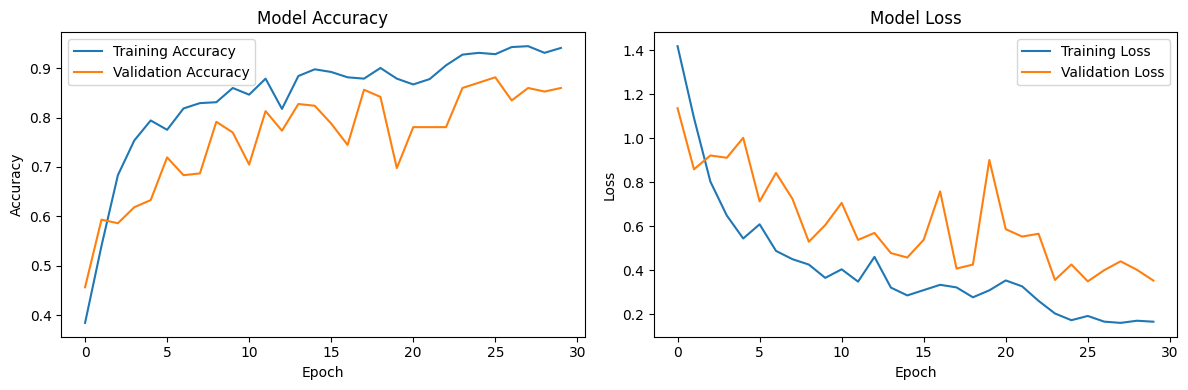

9/9 [==============================] - 6s 655ms/step - loss: 0.3197 - accuracy: 0.8777
Final validation accuracy: 0.8777


C:\Users\fahim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to: models/jute_disease_cnn_model.h5
Model configuration saved to: models/jute_disease_cnn_model_config.json


In [4]:
# Data Loading and Training
if not SKIP_TRAINING:
    print("Setting up data generators...")
    
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        DATASET_PATH,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        DATASET_PATH,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {validation_generator.samples}")
    
    # Training callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5)
    ]

    print(f"Starting training for {EPOCHS} epochs...")
    
    # Train the model
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=callbacks
    )

    print("Training completed!")
    
    # Plot training history
    def plot_training_history(history):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        ax1.plot(history.history['accuracy'], label='Training Accuracy')
        ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        
        ax2.plot(history.history['loss'], label='Training Loss')
        ax2.plot(history.history['val_loss'], label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

    plot_training_history(history)
    
    # Evaluate and save model
    val_loss, val_accuracy = model.evaluate(validation_generator)
    print(f"Final validation accuracy: {val_accuracy:.4f}")
    
    # Create models directory
    os.makedirs('models', exist_ok=True)
    
    # Save the model
    model.save(MODEL_PATH)
    print(f"Model saved to: {MODEL_PATH}")

    # Save model configuration
    model_config = {
        'model_name': 'jute_disease_cnn_model',
        'input_shape': list(IMG_SIZE) + [3],
        'num_classes': len(CLASS_NAMES),
        'class_names': CLASS_NAMES,
        'batch_size': BATCH_SIZE,
        'epochs_trained': len(history.history['loss']),
        'final_accuracy': float(val_accuracy),
        'final_loss': float(val_loss)
    }

    with open(CONFIG_PATH, 'w') as f:
        json.dump(model_config, f, indent=2)

    print(f"Model configuration saved to: {CONFIG_PATH}")
    
else:
    print("Skipping training - using existing model")

In [5]:
def predict_disease(image_path, model, class_names, img_size=(224, 224)):
    try:
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        
        predictions = model.predict(img_array, verbose=0)
        predicted_class_idx = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class_idx]
        
        all_probabilities = {class_names[i]: float(predictions[0][i]) for i in range(len(class_names))}
        
        return {
            'predicted_class': class_names[predicted_class_idx],
            'confidence': float(confidence),
            'all_probabilities': all_probabilities
        }
    except Exception as e:
        print(f"Error: {e}")
        return None

def analyze_jute_disease(image_path):
    print(f"Analyzing: {os.path.basename(image_path)}")
    
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None
        
    result = predict_disease(image_path, model, CLASS_NAMES, IMG_SIZE)
    
    if result:
        print(f"Diagnosis: {result['predicted_class']}")
        print(f"Confidence: {result['confidence']:.4f} ({result['confidence']*100:.1f}%)")
        
        if result['confidence'] > 0.8:
            print("High confidence")
        elif result['confidence'] > 0.6:
            print("Medium confidence")
        else:
            print("Low confidence")
        
        print("\nTop 3 predictions:")
        sorted_probs = sorted(result['all_probabilities'].items(), key=lambda x: x[1], reverse=True)
        for i, (class_name, prob) in enumerate(sorted_probs[:3]):
            print(f"  {i+1}. {class_name}: {prob:.4f} ({prob*100:.1f}%)")
        
        img = Image.open(image_path)
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(f"{result['predicted_class']} (Confidence: {result['confidence']*100:.1f}%)", 
                 fontsize=16, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    return result

In [6]:
print("Jute Disease Detection System Ready!")
print(f"Detects {len(CLASS_NAMES)} disease categories")
print(f"Classes: {', '.join(CLASS_NAMES)}")

if SKIP_TRAINING:
    print("Using existing trained model")
else:
    print("Ready for training")

Jute Disease Detection System Ready!
Detects 5 disease categories
Classes: Dieback, Fresh, Holed, Mosaic, Stem Soft Rot
Ready for training


## Disease Analysis

Testing with sample images:

In [7]:
# Test with sample images
sample_images = [
    'sample_images/fresh_sample.jpg',
    'sample_images/dieback_sample.jpg',
    'sample_images/holed_sample.jpg',
    'sample_images/mosaic_sample.jpg',
    'sample_images/stem_soft_rot_sample.jpg'
]

# Uncomment to test individual samples:
# result = analyze_jute_disease('sample_images/fresh_sample.jpg')
# result = analyze_jute_disease('sample_images/dieback_sample.jpg')
# result = analyze_jute_disease('path/to/your/image.jpg')

print("Available sample images:")
for img in sample_images:
    if os.path.exists(img):
        disease = os.path.basename(img).replace('_sample.jpg', '').replace('_', ' ').title()
        print(f"  {img} - {disease}")

Available sample images:
  sample_images/fresh_sample.jpg - Fresh
  sample_images/dieback_sample.jpg - Dieback
  sample_images/holed_sample.jpg - Holed
  sample_images/mosaic_sample.jpg - Mosaic
  sample_images/stem_soft_rot_sample.jpg - Stem Soft Rot



Analyzing: fresh_sample.jpg
Diagnosis: Fresh
Confidence: 0.6778 (67.8%)
Medium confidence

Top 3 predictions:
  1. Fresh: 0.6778 (67.8%)
  2. Holed: 0.1649 (16.5%)
  3. Mosaic: 0.1157 (11.6%)


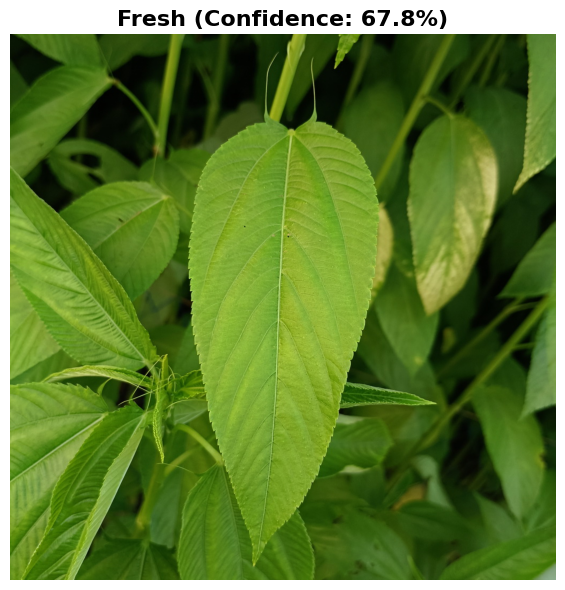


Analyzing: dieback_sample.jpg
Diagnosis: Dieback
Confidence: 0.9977 (99.8%)
High confidence

Top 3 predictions:
  1. Dieback: 0.9977 (99.8%)
  2. Stem Soft Rot: 0.0023 (0.2%)
  3. Mosaic: 0.0000 (0.0%)


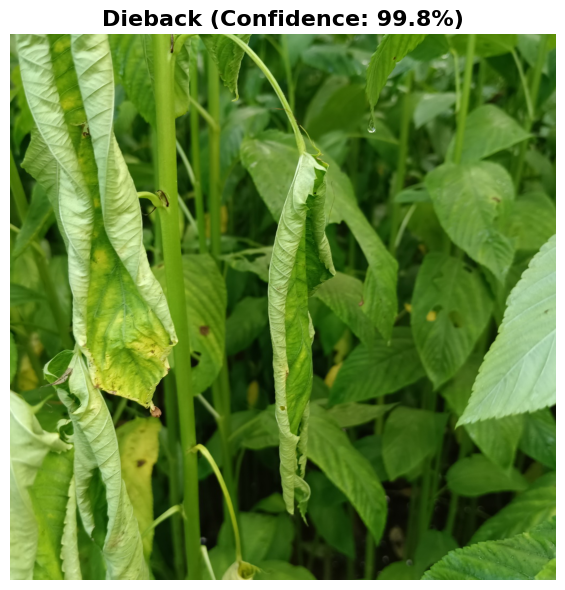


Analyzing: holed_sample.jpg
Diagnosis: Holed
Confidence: 0.7723 (77.2%)
Medium confidence

Top 3 predictions:
  1. Holed: 0.7723 (77.2%)
  2. Mosaic: 0.2035 (20.4%)
  3. Dieback: 0.0166 (1.7%)


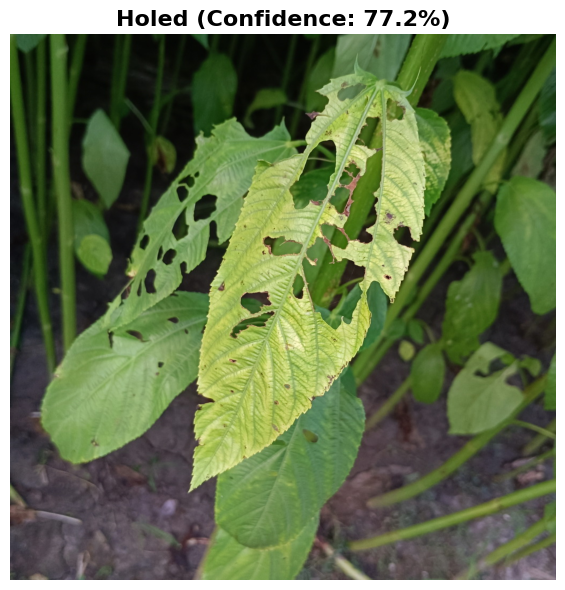


Analyzing: mosaic_sample.jpg
Diagnosis: Mosaic
Confidence: 0.9994 (99.9%)
High confidence

Top 3 predictions:
  1. Mosaic: 0.9994 (99.9%)
  2. Dieback: 0.0006 (0.1%)
  3. Holed: 0.0000 (0.0%)


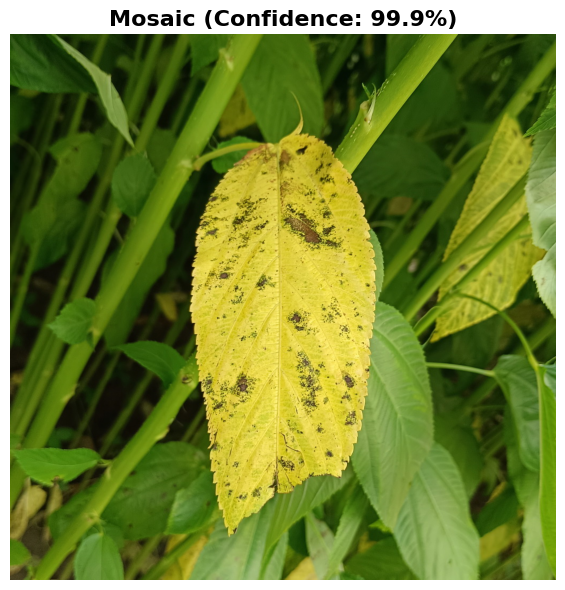


Analyzing: stem_soft_rot_sample.jpg
Diagnosis: Stem Soft Rot
Confidence: 0.9934 (99.3%)
High confidence

Top 3 predictions:
  1. Stem Soft Rot: 0.9934 (99.3%)
  2. Dieback: 0.0066 (0.7%)
  3. Fresh: 0.0000 (0.0%)


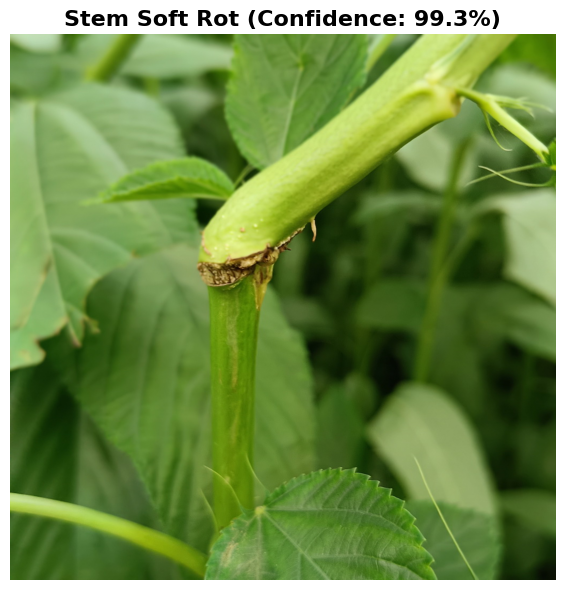

In [8]:
# Test all sample images
for image_path in sample_images:
    if os.path.exists(image_path):
        print(f"\n{'='*50}")
        result = analyze_jute_disease(image_path)
    else:
        print(f"Sample not found: {image_path}")